In [72]:
import os
import pandas as pd
from IPython.display import IFrame
import folium
import seaborn as sns
import glob
import networkx as nx
import numpy as np

# reading and formatting the data

In [2]:
loc='/Users/wentingjiang/Desktop/mda_kul_local/'

In [3]:
def read_noise_data(folder_path='export_40/'):
   # folder_path = 'export_40/'  # Replace with the path to your folder
    all_files = glob.glob(folder_path + "/*.csv")

    dfs = []
    for filename in all_files:
        data = pd.read_csv(filename, index_col=None, header=0, sep=';')

        data.loc[data['description'] == 'MP08bis - Vrijthof', 'description'] = 'MP 08: bis - Vrijthof'
        #data.loc[data['description'] == 'Naamsestraat 35  Maxim', 'description'] = 'MP 01: Naamsestraat 35 Maxim'

       #location_name = filename.split('.')[0].split('/')[-1].split('_')[-1]
       # print(location_name)
       # data['location']=location_name
        dfs.append(data)

    df_percentiled = pd.concat(dfs, axis=0, ignore_index=True)
    return df_percentiled

## Noise percentiled

In [4]:
df_percentiled= read_noise_data(loc+'export_40/')

In [5]:
df_percentiled.head()

,#object_id,description,result_timestamp,laf005_per_hour,laf005_per_hour_unit,laf01_per_hour,laf01_per_hour_unit,laf05_per_hour,laf05_per_hour_unit,laf10_per_hour,...,laf90_per_hour,laf90_per_hour_unit,laf95_per_hour,laf95_per_hour_unit,laf98_per_hour,laf98_per_hour_unit,laf99_per_hour,laf99_per_hour_unit,laf995_per_hour,laf995_per_hour_unit
0,255439,MP 01: Naamsestraat 35 Maxim,07/03/2022 13:00:00.000,65.4,dB(A),64.0,dB(A),60.5,dB(A),58.0,...,47.4,dB(A),46.4,dB(A),45.2,dB(A),44.8,dB(A),44.0,dB(A)
1,255439,MP 01: Naamsestraat 35 Maxim,07/03/2022 14:00:00.000,72.2,dB(A),70.8,dB(A),65.8,dB(A),62.6,...,45.2,dB(A),43.9,dB(A),42.4,dB(A),41.4,dB(A),40.4,dB(A)
2,255439,MP 01: Naamsestraat 35 Maxim,07/03/2022 15:00:00.000,74.5,dB(A),72.2,dB(A),66.0,dB(A),63.5,...,48.6,dB(A),47.3,dB(A),45.8,dB(A),45.2,dB(A),44.5,dB(A)
3,255439,MP 01: Naamsestraat 35 Maxim,07/03/2022 16:00:00.000,72.0,dB(A),70.3,dB(A),65.0,dB(A),62.0,...,45.4,dB(A),43.8,dB(A),42.4,dB(A),41.5,dB(A),40.9,dB(A)
4,255439,MP 01: Naamsestraat 35 Maxim,07/03/2022 17:00:00.000,72.6,dB(A),71.2,dB(A),66.6,dB(A),63.6,...,45.5,dB(A),43.8,dB(A),42.3,dB(A),41.4,dB(A),40.7,dB(A)


In [6]:
def create_location_name_dict(df_percentiled):

    pair_dict = {p.split(': ')[0]: p.split(': ')[1] for p in df_percentiled['description']}
    return pair_dict

In [7]:
location_dict=create_location_name_dict(df_percentiled)
location_dict

{'MP 01': 'Naamsestraat 35  Maxim',
 'MP 03': 'Naamsestraat 62 Taste',
 'MP 05': 'Calvariekapel KU Leuven',
 'MP 06': 'Parkstraat 2 La Filosovia',
 'MP 08': 'bis - Vrijthof',
 'MP 02': 'Naamsestraat 57 Xior',
 'MP 07': 'Naamsestraat 81',
 'MP 04': 'His & Hears'}

In [25]:
def truncate_time_to_min(df):
    df['timestamp'] = df['result_timestamp'].str[:-7]
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df['timestamp'] = df['timestamp'].dt.strftime('%Y-%m-%d %H:%M')
    
    return df.drop('result_timestamp', axis=1)

In [9]:
df_percentiled2 = truncate_time_to_min(df_percentiled)

In [13]:
def generate_noise_network_percentiled(df):
    """
    function unfinished
    """
    
# Create a graph with nodes representing monitoring stations
    G = nx.Graph()
    for station in df['description'].unique():
        G.add_node(station, name=station)

    # Add edges between nodes based on noise level correlations
    for station1 in df['description'].unique():
        for station2 in df['description'].unique():
            if station1 != station2:
                noise1 = df[df['description'] == station1]#['laf005_per_hour'].values
                noise2 = df[df['description'] == station2]#['laf005_per_hour'].values
                result = pd.merge(noise1, noise2, on='result_timestamp', how='inner')

                corr = np.corrcoef(result['laf005_per_hour_x'], result['laf005_per_hour_y'])[0,1]
                if corr > 0.8:
                    G.add_edge(station1, station2, weight=corr)

    # Use community detection algorithm to identify clusters
    communities = nx.community.greedy_modularity_communities(G)

    # Visualize the graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos=pos, node_color=[communities.index(c) for n,c in nx.get_node_attributes(G,'community').items()], cmap='tab20')
    
    #generate_noise_network_percentiled(df_percentiled2)

## Noise level

In [7]:
loc+'export_42/**/'

'/Users/wentingjiang/Desktop/mda_kul_local/export_42/**/'

In [55]:
df_noise_level = read_noise_data(loc+'export_42/March/')

# change to loc+'export_42/**/' for reading all months, but the kernel will crash
# just read data for march for now

In [56]:
df_noise_level.head()

,#object_id,description,result_timestamp,lamax,lamax_unit,laeq,laeq_unit,lceq,lceq_unit,lcpeak,lcpeak_unit
0,280324,MP 08: bis - Vrijthof,30/03/2022 14:46:45.725,50.0,dB(A),49.5,dB(A),61.11,dB(C),71.39,dB(C)
1,280324,MP 08: bis - Vrijthof,30/03/2022 14:46:46.725,50.5,dB(A),50.0,dB(A),63.97,dB(C),73.63,dB(C)
2,280324,MP 08: bis - Vrijthof,30/03/2022 14:46:47.725,50.3,dB(A),49.7,dB(A),62.55,dB(C),72.95,dB(C)
3,280324,MP 08: bis - Vrijthof,30/03/2022 14:46:48.725,51.0,dB(A),50.5,dB(A),62.83,dB(C),73.21,dB(C)
4,280324,MP 08: bis - Vrijthof,30/03/2022 14:46:49.725,52.2,dB(A),51.1,dB(A),63.00,dB(C),73.59,dB(C)


In [57]:
df_noise_level.shape

(16167360, 11)

In [15]:
# there are only 4 locations
df_noise_level['description'].unique()

array(['MP 06: Parkstraat 2 La Filosovia', 'MP 07: Naamsestraat 81',
       'MP 05: Calvariekapel KU Leuven', 'MP 02: Naamsestraat 57 Xior',
       'MP 03: Naamsestraat 62 Taste', 'MP 01: Naamsestraat 35  Maxim'],
      dtype=object)

In [17]:
#test = df_noise_level.copy()
#test['timestamp'] = test['result_timestamp'].str[:-12]
#test.timestamp.unique()

In [58]:
def get_average_noise_level_per_min(df_noise_level):
    
    # reduce to min precision 
    df_noise_level['timestamp'] = df_noise_level['result_timestamp'].str[:-7]
    
    df_noise_level_min=df_noise_level.groupby(['description', 'timestamp'])['lamax'].mean().reset_index()
    
    print(df_noise_level_min.groupby('description').count())
    
    df_noise_level_min_wide = pd.pivot_table(df_noise_level_min, values='lamax', index='timestamp', columns='description')

    # some locations have more timestamps, make them equal length of time stamp
  #  df_noise_level_min_clean = df_noise_level_min_wide.reset_index().dropna()
    df_noise_level_min_clean = df_noise_level_min_wide.reset_index()
    
    # locations have high corr for the noise level
    # print(df_noise_level_min_clean.corr())
    
    # make the precision to minute level (double check later if this is sufficient)
    df_noise_level_min_clean['timestamp'] = pd.to_datetime(df_noise_level_min_clean['timestamp'], errors='coerce')
    df_noise_level_min_clean['timestamp'] = df_noise_level_min_clean['timestamp'].dt.strftime('%Y-%m-%d %H:%M')
    
    return df_noise_level_min_clean

In [59]:
df_noise_mean=get_average_noise_level_per_min(df_noise_level)

                                  timestamp  lamax
description                                       
MP 01: Naamsestraat 35  Maxim         44579  44579
MP 02: Naamsestraat 57 Xior           44578  44578
MP 03: Naamsestraat 62 Taste          44580  44580
MP 05: Calvariekapel KU Leuven        44580  44580
MP 06: Parkstraat 2 La Filosovia      44580  44580
MP 07: Naamsestraat 81                44580  44580
MP 08: bis - Vrijthof                  1994   1994


In [60]:
df_noise_mean.head() # location MP 08: bis - Vrijthof does not have the noise level info?

description,timestamp,MP 01: Naamsestraat 35 Maxim,MP 02: Naamsestraat 57 Xior,MP 03: Naamsestraat 62 Taste,MP 05: Calvariekapel KU Leuven,MP 06: Parkstraat 2 La Filosovia,MP 07: Naamsestraat 81,MP 08: bis - Vrijthof
0,2022-01-03 00:00,62.230000,46.628333,47.656667,54.370000,53.406667,53.023333,NaN
1,2022-01-03 00:01,61.503333,47.635000,51.345000,52.018333,50.746667,44.916667,NaN
2,2022-01-03 00:02,64.036667,51.831667,58.003333,52.098333,47.891667,52.850000,NaN
3,2022-01-03 00:03,62.131667,53.106667,51.691667,46.216667,52.708333,60.041667,NaN
4,2022-01-03 00:04,61.995000,58.546667,51.648333,57.956667,59.280000,47.965000,NaN


In [46]:
df_noise_mean.dtypes

description
timestamp                            object
MP 01: Naamsestraat 35  Maxim       float64
MP 02: Naamsestraat 57 Xior         float64
MP 03: Naamsestraat 62 Taste        float64
MP 05: Calvariekapel KU Leuven      float64
MP 06: Parkstraat 2 La Filosovia    float64
MP 07: Naamsestraat 81              float64
dtype: object

## Noise events

In [22]:
df_noise_events = read_noise_data(loc+'export_41/')

In [23]:
import datetime as dt

In [26]:
df_noise_events2 =truncate_time_to_min(df_noise_events)

In [27]:
def print_na_percent(df):
    print(df.isna().sum()/df.shape[0])

In [28]:
print_na_percent(df_noise_events)

#object_id                                          0.000000
description                                         0.000000
result_timestamp                                    0.000000
noise_event_laeq_model_id                           0.047153
noise_event_laeq_model_id_unit                      1.000000
noise_event_laeq_primary_detected_certainty         0.047153
noise_event_laeq_primary_detected_certainty_unit    0.000000
noise_event_laeq_primary_detected_class             0.047153
noise_event_laeq_primary_detected_class_unit        1.000000
timestamp                                           0.000000
dtype: float64


In [29]:
def remove_noise_undetected(df):
    #print() how many removed
    return df[~df['noise_event_laeq_primary_detected_certainty'].isna()]

In [30]:
df_noise_events_detected=remove_noise_undetected(df_noise_events2)
df_noise_events_detected.shape

(77234, 9)

In [31]:
df_noise_events_detected.groupby('noise_event_laeq_primary_detected_class').count()

,#object_id,description,noise_event_laeq_model_id,noise_event_laeq_model_id_unit,noise_event_laeq_primary_detected_certainty,noise_event_laeq_primary_detected_certainty_unit,noise_event_laeq_primary_detected_class_unit,timestamp
noise_event_laeq_primary_detected_class,,,,,,,,
Human voice - Shouting,5742,5742,5742,0,5742,5742,0,5742
Human voice - Singing,1082,1082,1082,0,1082,1082,0,1082
Music non-amplified,126,126,126,0,126,126,0,126
Nature elements - Wind,113,113,113,0,113,113,0,113
Transport road - Passenger car,47388,47388,47388,0,47388,47388,0,47388
Transport road - Siren,1992,1992,1992,0,1992,1992,0,1992
Unsupported,20791,20791,20791,0,20791,20791,0,20791


In [32]:
df_noise_events_detected['description'].unique()

array(['MP 07: Naamsestraat 81', 'MP 06: Parkstraat 2 La Filosovia',
       'MP 02: Naamsestraat 57 Xior', 'MP 03: Naamsestraat 62 Taste',
       'MP 01: Naamsestraat 35  Maxim', 'MP 08: bis - Vrijthof',
       'MP 05: Calvariekapel KU Leuven'], dtype=object)

In [33]:
def get_noise_type_by_time_location(df_noise_events_detected):

    df_noise_type=df_noise_events_detected.groupby(['description',
                                      'timestamp',
        'noise_event_laeq_primary_detected_class']).count().reset_index()

    df_noise_type_wide = pd.pivot_table(df_noise_type, values='noise_event_laeq_model_id', index=['description','timestamp'], columns='noise_event_laeq_primary_detected_class')
    return df_noise_type_wide.reset_index().fillna(0)

In [34]:
df_noise_type_wide = get_noise_type_by_time_location(df_noise_events_detected)

In [85]:
# noise_cat = ['Human voice - Shouting',
#        'Human voice - Singing', 'Music non-amplified',
#        'Nature elements - Wind', 'Transport road - Passenger car',
#        'Transport road - Siren', 'Unsupported']
# # sometimes, many events can happen in one minute at one location
# for i in noise_cat:
#     print(i)
#     print(df_noise_type_wide[i].max())
#     print(df_noise_type_wide[i].median())

In [26]:
# some standard processing to do:
# limit to the noise at night
# change the location to include abbreviations only

## Join noise level and events data

In [48]:
df_noise_mean.head()

description,timestamp,MP 01: Naamsestraat 35 Maxim,MP 02: Naamsestraat 57 Xior,MP 03: Naamsestraat 62 Taste,MP 05: Calvariekapel KU Leuven,MP 06: Parkstraat 2 La Filosovia,MP 07: Naamsestraat 81
39735,2022-02-28 14:15,54.885000,51.516667,53.678333,51.928333,58.398333,61.483333
39751,2022-02-28 14:31,56.590000,57.616667,60.055000,62.323333,59.273333,58.846667
39761,2022-02-28 14:41,56.403333,52.600000,52.803333,57.136667,56.775000,61.081667
39777,2022-02-28 14:57,56.850000,56.016667,55.438333,52.966667,53.063333,51.996667
39794,2022-02-28 15:14,51.250000,55.883333,55.510000,55.383333,57.256667,56.326667


In [65]:
merged_df=df_noise_type_wide.merge(df_noise_mean, on='timestamp', how='left')
merged = merged_df[~merged_df['MP 03: Naamsestraat 62 Taste'].isna()]

In [67]:
merged.head()

,description,timestamp,Human voice - Shouting,Human voice - Singing,Music non-amplified,Nature elements - Wind,Transport road - Passenger car,Transport road - Siren,Unsupported,MP 01: Naamsestraat 35 Maxim,MP 02: Naamsestraat 57 Xior,MP 03: Naamsestraat 62 Taste,MP 05: Calvariekapel KU Leuven,MP 06: Parkstraat 2 La Filosovia,MP 07: Naamsestraat 81,MP 08: bis - Vrijthof
2049,MP 01: Naamsestraat 35 Maxim,2022-03-13 00:04,0.0,0.0,0.0,1.0,0.0,0.0,0.0,57.058333,58.060000,57.230000,54.596667,53.296667,52.251667,NaN
2050,MP 01: Naamsestraat 35 Maxim,2022-03-13 01:10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,65.716667,67.745000,54.266667,48.328333,47.306667,47.385000,NaN
2051,MP 01: Naamsestraat 35 Maxim,2022-03-13 02:01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,51.951667,49.876667,48.370000,44.360000,43.225000,45.505000,NaN
2052,MP 01: Naamsestraat 35 Maxim,2022-03-13 03:11,0.0,0.0,0.0,0.0,1.0,0.0,0.0,52.743333,57.486667,53.986667,51.028333,44.400000,37.635000,NaN
2053,MP 01: Naamsestraat 35 Maxim,2022-03-13 03:39,1.0,0.0,0.0,0.0,0.0,0.0,0.0,58.396667,55.428333,48.691667,50.928333,52.811667,47.116667,NaN


In [38]:
len(merged['timestamp'].unique()) == merged.shape[0]
# each timestamp corresponds to only one event here

True

In [69]:
merged.columns

Index(['description', 'timestamp', 'Human voice - Shouting',
       'Human voice - Singing', 'Music non-amplified',
       'Nature elements - Wind', 'Transport road - Passenger car',
       'Transport road - Siren', 'Unsupported',
       'MP 01: Naamsestraat 35  Maxim', 'MP 02: Naamsestraat 57 Xior',
       'MP 03: Naamsestraat 62 Taste', 'MP 05: Calvariekapel KU Leuven',
       'MP 06: Parkstraat 2 La Filosovia', 'MP 07: Naamsestraat 81',
       'MP 08: bis - Vrijthof'],
      dtype='object')

In [68]:
merged.groupby('description').count()
# all noise happen at this one location (the dataset seems incomplete)

,timestamp,Human voice - Shouting,Human voice - Singing,Music non-amplified,Nature elements - Wind,Transport road - Passenger car,Transport road - Siren,Unsupported,MP 01: Naamsestraat 35 Maxim,MP 02: Naamsestraat 57 Xior,MP 03: Naamsestraat 62 Taste,MP 05: Calvariekapel KU Leuven,MP 06: Parkstraat 2 La Filosovia,MP 07: Naamsestraat 81,MP 08: bis - Vrijthof
description,,,,,,,,,,,,,,,
MP 01: Naamsestraat 35 Maxim,1321,1321,1321,1321,1321,1321,1321,1321,1321,1321,1321,1321,1321,1321,78
MP 02: Naamsestraat 57 Xior,457,457,457,457,457,457,457,457,457,457,457,457,457,457,33
MP 03: Naamsestraat 62 Taste,650,650,650,650,650,650,650,650,650,650,650,650,650,650,33
MP 05: Calvariekapel KU Leuven,1055,1055,1055,1055,1055,1055,1055,1055,1055,1055,1055,1055,1055,1055,43
MP 06: Parkstraat 2 La Filosovia,853,853,853,853,853,853,853,853,853,853,853,853,853,853,49
MP 07: Naamsestraat 81,2468,2468,2468,2468,2468,2468,2468,2468,2468,2466,2468,2468,2468,2468,73


In [76]:
from sklearn.model_selection import train_test_split

In [77]:
# load dataset features
X = merged[['MP 03: Naamsestraat 62 Taste',
       'MP 05: Calvariekapel KU Leuven', 'MP 06: Parkstraat 2 La Filosovia',
       'MP 07: Naamsestraat 81']]

#y_human_voice = np.array(merged['Human voice - Shouting'])
# just to predict whether or not it is passenger car
y_car = np.array(merged['Transport road - Passenger car'])

# split dataset into training and testing sets

# if there are two events in the same minute, just change to 1
# Replace all 2's with 1's
y = np.where(y_car > 1, 1, y_car)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y,
                                                    test_size=0.2, random_state=42)

In [78]:
sum(y)/len(y)  # class imbalance

0.6535861258083481

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [83]:
# create logistic regression model
clf = LogisticRegression() #multi_class='multinomial', solver='lbfgs'

# fit the model on the training data
clf.fit(X_train, y_train)

# predict the labels for the test data
y_pred = clf.predict(X_test)

# evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# print the classification report
#report = classification_report(y_test, y_pred)
#print(report)

Accuracy: 0.7068332108743571


/Users/wentingjiang/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


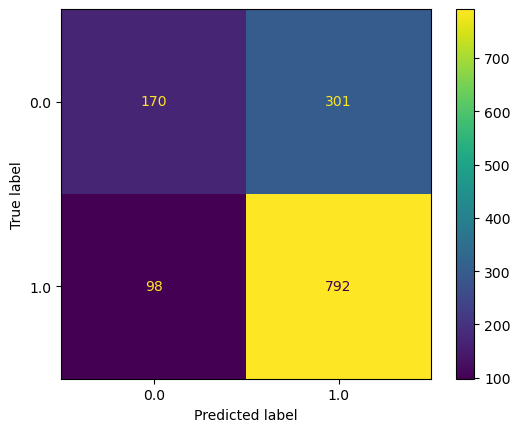

In [84]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plot_confusion_matrix(clf, X_test, y_test)
plt.show()


## Archive

In [ ]:
# try to draw a network where the coordinates info is represented in the graph

# import matplotlib.pyplot as plt

# # Create an empty graph
# G = nx.Graph()

# # Add nodes to the graph with geographic coordinates
# G.add_node("Node 1", pos=(50.879, 4.700))
# G.add_node("Node 2", pos=(50.878, 4.701))
# G.add_node("Node 3", pos=(40.878, 5.701))

# # Add edges to the graph
# G.add_edge("Node 1", "Node 2")

# # Draw the graph with geographic coordinates
# pos = nx.get_node_attributes(G, 'pos')
# nx.draw(G, pos, with_labels=True)
# plt.show()

In [ ]:
# how to process time stamp conversion more effectively
# def convert_to_datetime(timestamp):
#     return pd.to_datetime(timestamp)

# # set number of worker processes
# num_workers = 4

# # create multiprocessing pool
# pool = Pool(num_workers)

# # convert timestamp column to datetime objects in parallel
# df['timestamp'] = pool.map(convert_to_datetime, df['timestamp'])

# # close multiprocessing pool
# pool.close()

# print(df.head())